# Copyright Netherlands eScience Center <br>
** Function     : Computing AMET with Surface & TOA flux** <br>
** Author       : Yang Liu ** <br>
** First Built  : 2019.08.09 ** <br>
** Last Update  : 2019.08.09 ** <br>
Description     : This notebook aims to compute AMET with TOA/surface flux fields from HadGEM model. The HadGEM model is launched by UoS in Blue Action Work Package 3 as coordinated experiments for joint analysis. It contributes to the Deliverable 3.1. <br>
Return Values   : netCDF4 <br>
Caveat          : The fields used here are post-processed monthly mean fields. Hence there is no accumulation that need to be taken into account.<br>

The **positive sign** for each variable varies:<br>
* Latent heat flux (LH_surface) - upward <br>
* Sensible heat flux (SH_surface) - upward <br>
* Net solar radiation flux at TOA (SW_TOA)- upward <br>
* Net solar radiation flux at surface (SW_surface) - downward <br>
* Net longwave radiation flux at surface (LW_surface) - downward <br>
* Net longwave radiation flux at TOA (LWout_TOA) - upward <br>

In [3]:
%matplotlib inline
import numpy as np
import sys
sys.path.append("/home/ESLT0068/NLeSC/Computation_Modeling/Bjerknes/Scripts/META")
import scipy as sp
import time as tttt
from netCDF4 import Dataset,num2date
import os
import meta.statistics
import meta.visualizer
import matplotlib.pyplot as plt

In [4]:
# constants
constant = {'g' : 9.80616,      # gravititional acceleration [m / s2]
            'R' : 6371009,      # radius of the earth [m]
            'cp': 1004.64,      # heat capacity of air [J/(Kg*K)]
            'Lv': 2264670,      # Latent heat of vaporization [J/Kg]
            'R_dry' : 286.9,    # gas constant of dry air [J/(kg*K)]
            'R_vap' : 461.5,    # gas constant for water vapour [J/(kg*K)]
            }

In [17]:
################################   Input zone  ######################################
# specify starting and ending time
start_year = 1979
end_year = 2014
# specify data path
datapath = '/home/ESLT0068/WorkFlow/Core_Database_BlueAction_WP3/HadGEM_UoS'
# specify output path for figures
output_path = '/home/ESLT0068/WorkFlow/Core_Database_BlueAction_WP3/AMET_netCDF'
# ensemble number
ensemble_12 = 10 # exp 1 & 2
ensemble_34 = 5 # exp 3 & 4
# experiment number
exp = 4
# example file
#datapath_example = os.path.join(datapath, 'SH_surface', 'SH_surface_1m_EXP1-ENS01.nc')
datapath_example = os.path.join(datapath, 'SW_TOA', 'SW_TOA_1m_EXP1-ENS01.nc') # problem with this field

####################################################################################

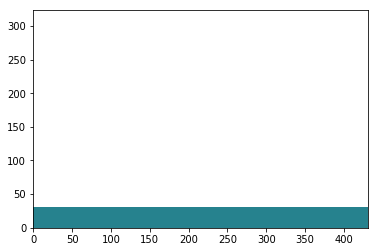

In [16]:
key_example = Dataset(datapath_example)
lat = key_example.variables['latitude'][::-1]
lon = key_example.variables['longitude'][:]
sh = key_example.variables['sw'][:,0,::-1,:]
plt.contourf(sh[0,:,:])

plt.show()

In [4]:
def var_key_retrieve(datapath, exp_num, ensemble_num):
    # get the path to each datasets
    print ("Start retrieving datasets of experiment {} ensemble number {}".format(exp_num+1, ensemble_num))
    # get data path
    if exp_num<2:
        datapath_slhf = os.path.join(datapath, 'LH_surface', 'LH_surface_1m_EXP{}-ENS{}.nc'.format(exp_num+1, ensemble_list[ensemble_num]))
        datapath_sshf = os.path.join(datapath, 'SH_surface', 'SH_surface_1m_EXP{}-ENS{}.nc'.format(exp_num+1, ensemble_list[ensemble_num]))
        datapath_ssr = os.path.join(datapath, 'SW_surface', 'SW_surface_1m_EXP{}-ENS{}.nc'.format(exp_num+1, ensemble_list[ensemble_num]))
        datapath_str = os.path.join(datapath, 'LW_surface', 'LW_surface_1m_EXP{}-ENS{}.nc'.format(exp_num+1, ensemble_list[ensemble_num]))
        datapath_tsr = os.path.join(datapath, 'SW_TOA', 'SW_TOA_1m_EXP{}-ENS{}.nc'.format(exp_num+1, ensemble_list[ensemble_num]))
        datapath_ttr = os.path.join(datapath, 'LWout_TOA', 'LWout_TOA_1m_EXP{}-ENS{}.nc'.format(exp_num+1, ensemble_list[ensemble_num]))
    else:
        datapath_slhf = os.path.join(datapath, 'LH_surface', 'LH_surface_1m_EXP{}-ENS{}.nc'.format(exp_num+1, ensemble_list[ensemble_num]))
        datapath_sshf = os.path.join(datapath, 'SH_surface', 'SH_surface_1m_EXP{}-ENS{}.nc'.format(exp_num+1, ensemble_list[ensemble_num]))
        datapath_ssr = os.path.join(datapath, 'SW_surface', 'SW_surface_1m_EXP{}-ENS{}.nc'.format(exp_num+1, ensemble_list[ensemble_num]))
        datapath_str = os.path.join(datapath, 'LW_surface', 'LW_surface_1m_EXP{}-ENS{}.nc'.format(exp_num+1, ensemble_list[ensemble_num]))
        datapath_tsr = os.path.join(datapath, 'SW_TOA', 'SW_TOA_1m_EXP{}-ENS{}.nc'.format(exp_num+1, ensemble_list[ensemble_num]))
        datapath_ttr = os.path.join(datapath, 'LWout_TOA', 'LWout_TOA_1m_EXP{}-ENS{}.nc'.format(exp_num+1, ensemble_list[ensemble_num]))
    # get the variable keys    
    key_slhf = Dataset(datapath_slhf)
    key_sshf = Dataset(datapath_sshf)
    key_ssr = Dataset(datapath_ssr)
    key_str = Dataset(datapath_str)
    key_tsr = Dataset(datapath_tsr)
    key_ttr = Dataset(datapath_ttr)

    print ("Retrieving datasets successfully and return the variable key!")
    return key_slhf, key_sshf, key_ssr, key_str, key_tsr, key_ttr

In [5]:
def amet(key_slhf, key_sshf, key_ssr, key_str, key_tsr, key_ttr, lat, lon):
    # get all the varialbes
    # make sure we know the sign of all the input variables!!!
    # descending lat
    # Caveat! pay attention that the dimensions of the input fields are [432, 1, 324, 432]
    var_slhf = key_slhf.variables['lh'][:,0,::-1,:] # surface latent heat flux W/m2
    #print(var_slhf.shape)
    var_sshf = key_sshf.variables['sh'][:,0,::-1,:] # surface sensible heat flux W/m2
    #print(var_sshf.shape)
    var_ssr = key_ssr.variables['solar'][:,0,::-1,:] # surface solar radiation W/m2
    #print(var_ssr.shape)
    var_str = key_str.variables['longwave'][:,0,::-1,:] # surface thermal radiation W/m2
    var_tsr = key_tsr.variables['sw'][:,0,::-1,:] # TOA solar radiation W/m2
    var_ttr = key_ttr.variables['olr'][:,0,::-1,:] # TOA thermal radiation W/m2
    #size of the grid box
    dx = 2 * np.pi * constant['R'] * np.cos(2 * np.pi * lat /
                                            360) / len(lon) 
    dy = np.pi * constant['R'] / len(lat)
    # calculate total net energy flux at TOA/surface
    net_flux_surf = - var_slhf - var_sshf + var_ssr + var_str
    #print(net_flux_surf.shape)
    net_flux_toa = - var_tsr - var_ttr
    net_flux_surf_area = np.zeros(net_flux_surf.shape, dtype=float) # unit W
    net_flux_toa_area = np.zeros(net_flux_toa.shape, dtype=float)

    for i in np.arange(len(lat)):
        # change the unit to terawatt
        net_flux_surf_area[:,i,:] = net_flux_surf[:,i,:]* dx[i] * dy / 1E+12
        net_flux_toa_area[:,i,:] = net_flux_toa[:,i,:]* dx[i] * dy / 1E+12
    
    # take the zonal integral of flux
    net_flux_surf_int = np.sum(net_flux_surf_area,2) / 1000 # PW
    net_flux_toa_int = np.sum(net_flux_toa_area,2) / 1000
    # AMET as the residual of net flux at TOA & surface
    AMET_res_ERAI = np.zeros(net_flux_surf_int.shape)
    for i in np.arange(len(lat)):
        AMET_res_ERAI[:,i] = -(np.sum(net_flux_toa_int[:,0:i+1],1) -
                                np.sum(net_flux_surf_int[:,0:i+1],1))
    AMET_res_ERAI = AMET_res_ERAI.reshape(-1,12,len(lat))
    return AMET_res_ERAI

In [6]:
def create_netcdf_point (pool_amet, lat, output_path, exp):
    print ('*******************************************************************')
    print ('*********************** create netcdf file*************************')
    print ('*******************************************************************')
    #logging.info("Start creating netcdf file for the 2D fields of ERAI at each grid point.")
    # get the basic dimensions
    ens, year, month, _ = pool_amet.shape
    # wrap the datasets into netcdf file
    # 'NETCDF3_CLASSIC', 'NETCDF3_64BIT', 'NETCDF4_CLASSIC', and 'NETCDF4'
    data_wrap = Dataset(os.path.join(output_path, 'amet_HadGEM_UoS_exp{}.nc'.format(exp+1)),'w',format = 'NETCDF4')
    # create dimensions for netcdf data
    ens_wrap_dim = data_wrap.createDimension('ensemble', ens)
    year_wrap_dim = data_wrap.createDimension('year', year)
    month_wrap_dim = data_wrap.createDimension('month', month)
    lat_wrap_dim = data_wrap.createDimension('latitude', len(lat))
    # create coordinate variable
    ens_wrap_var = data_wrap.createVariable('ensemble',np.int32,('ensemble',))
    year_wrap_var = data_wrap.createVariable('year',np.int32,('year',))
    month_wrap_var = data_wrap.createVariable('month',np.int32,('month',))
    lat_wrap_var = data_wrap.createVariable('latitude',np.float32,('latitude',))
    # create the actual 4d variable
    amet_wrap_var = data_wrap.createVariable('amet',np.float64,('ensemble','year','month','latitude'),zlib=True)  
    # global attributes
    data_wrap.description = 'Monthly mean atmospheric meridional energy transport'
    # variable attributes
    lat_wrap_var.units = 'degree_north'
    amet_wrap_var.units = 'PW'
    amet_wrap_var.long_name = 'atmospheric meridional energy transport'
    # writing data
    ens_wrap_var[:] = np.arange(ens)
    month_wrap_var[:] = np.arange(month)+1
    year_wrap_var[:] = np.arange(year)+1979
    lat_wrap_var[:] = lat

    amet_wrap_var[:] = pool_amet

    # close the file
    data_wrap.close()
    print ("The generation of netcdf files is complete!!")

In [7]:
if __name__=="__main__":
    ####################################################################
    ######  Create time namelist matrix for variable extraction  #######
    ####################################################################
    # date and time arrangement
    # namelist of month and days for file manipulation
    namelist_month = ['01','02','03','04','05','06','07','08','09','10','11','12']
    ensemble_list = ['01','02','03','04','05','06','07','08','09','10',
                     '11','12','13','14','15','16','17','18','19','20',
                     '21','22','23','24','25','26','27','28','29','30',]
    # index of months
    period_1979_2014 = np.arange(start_year,end_year+1,1)
    period_1979_2013 = period_1979_2014[:-1]
    index_month = np.arange(1,13,1)
    ####################################################################
    ######       Extract invariant and calculate constants       #######
    ####################################################################
    # get basic dimensions from sample file
    key_example = Dataset(datapath_example)
    lat = key_example.variables['latitude'][::-1] # descending lat
    print(lat)
    lon = key_example.variables['longitude'][:]
    print(lon)
    # get invariant from benchmark file
    Dim_year_1979_2014 = len(period_1979_2014)
    Dim_year_1979_2013 = len(period_1979_2013)
    Dim_month = len(index_month)
    Dim_latitude = len(lat)
    Dim_longitude = len(lon)
    #############################################
    #####   Create space for stroing data   #####
    #############################################

    # loop for calculation
    for i in range(exp):
        if i < 2:
            ensemble = ensemble_12
            pool_amet = np.zeros((ensemble,Dim_year_1979_2014,Dim_month,Dim_latitude),dtype = float)
        else:
            ensemble = ensemble_34
            pool_amet = np.zeros((ensemble,Dim_year_1979_2013,Dim_month,Dim_latitude),dtype = float)
        for j in range(ensemble):
            # get variable keys
            key_slhf, key_sshf, key_ssr, key_str, key_tsr,\
            key_ttr = var_key_retrieve(datapath, i, j)
            # compute amet
            pool_amet[j,:,:,:] = amet(key_slhf, key_sshf, key_ssr,
                                      key_str, key_tsr, key_ttr, lat, lon)              
        ####################################################################
        ######                 Data Wrapping (NetCDF)                #######
        ####################################################################
        # save netcdf
        create_netcdf_point(pool_amet, lat, output_path, i)
        print ('Packing AMET is complete!!!')
        print ('The output is in sleep, safe and sound!!!')

[ 89.72223     89.16667     88.61112     88.055565    87.50001
  86.94445     86.38889     85.83334     85.27779     84.72223
  84.16667     83.61112     83.055565    82.50001     81.94445
  81.38889     80.83334     80.27779     79.72223     79.16667
  78.611115    78.055565    77.50001     76.94445     76.38889
  75.83334     75.27779     74.72223     74.16667     73.611115
  73.055565    72.50001     71.94445     71.38889     70.83334
  70.27779     69.72223     69.16667     68.611115    68.055565
  67.50001     66.94445     66.38889     65.83334     65.27779
  64.72223     64.16667     63.61112     63.05556     62.500008
  61.94445     61.388897    60.83334     60.277782    59.72223
  59.16667     58.61112     58.05556     57.500008    56.94445
  56.388893    55.83334     55.277782    54.72223     54.16667
  53.61112     53.05556     52.500008    51.94445     51.388893
  50.83334     50.277782    49.72223     49.16667     48.61112
  48.05556     47.500008    46.94445     46.388893 